In [1]:
import pandas as pd
import time
import numpy as np
import json
import os
from collections import defaultdict
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit
from heavy_tail_regressions import _cal_psi, _cal_ap

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [31]:
data = pd.read_csv("/home/rai/다운로드/lastfm_train//train_triplets.txt", sep="\t", names=['user', 'song', 'number of play'])
data = data[:100000]

In [32]:
tracks = pd.read_csv("/home/rai/다운로드/lastfm_train/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])
tr = tracks[['track','song']]
tr

/tmp/ipykernel_39458/2843548712.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tracks = pd.read_csv("/home/rai/다운로드/lastfm_train/unique_tracks.txt", sep="<SEP>", names=['track', 'song', 'artist', 'title'])


,track,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF
...,...,...
999995,TRYYYUS12903CD2DF0,SOTXAME12AB018F136
999996,TRYYYJO128F426DA37,SOXQYIQ12A8C137FBB
999997,TRYYYMG128F4260ECA,SOHODZI12A8C137BB3
999998,TRYYYDJ128F9310A21,SOLXGOR12A81C21EB7


In [33]:
tag_list = pd.read_csv('/home/rai/다운로드/lastfm_train//lastfm_unique_tags.txt',sep='\t',names=['genre','counts'])
tag_list

,genre,counts
0,rock,101071
1,pop,69159
2,alternative,55777
3,indie,48175
4,electronic,46270
...,...,...
522361,´rock,1
522362,Örebro,1
522363,äh,1
522364,ångest,1


In [ ]:
tag_freq = tag_list[tag_list['counts']>10000]
tag_freq = list(tag_freq['genre'])
print(len(tag_freq))
tag_freq

In [35]:
data = pd.merge(data, tr)
data = data.drop(['song'],axis=1)
data

,user,number of play,track
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,TRIQAUQ128F42435AD
1,7c86176941718984fed11b7c0674ff04c029b480,1,TRIQAUQ128F42435AD
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,3,TRIQAUQ128F42435AD
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,1,TRIQAUQ128F42435AD
4,3f73f44560e822344b0fb7c6b463869743eb9860,6,TRIQAUQ128F42435AD
...,...,...,...
102622,3887c145fb91a26b3ce9c80903231539411c601e,2,TRNFCCE12903CD707E
102623,3887c145fb91a26b3ce9c80903231539411c601e,1,TRMEMTI128F92E5141
102624,3887c145fb91a26b3ce9c80903231539411c601e,5,TRIQAWG128F932B6F6
102625,3887c145fb91a26b3ce9c80903231539411c601e,4,TRHVBCS128F932B6E8


In [ ]:
df = pd.DataFrame(columns=['track', 'tags'])
tags = []
count = 0
for t in data['track']:
    path = '/home/rai/다운로드/lastfm_train/' + t[2] + '/' + t[3] + '/' + t[4]
    if t + '.json' in os.listdir(path):
        with open(path + '/' + t + '.json') as f:
            dt = json.load(f)
        df2 = pd.DataFrame({'track' : dt['track_id'], 'tags' : dt['tags']})
        df = df.append(df2, ignore_index=True)
    count += 1
    if count % 500 == 0:
        print(count)
df

In [ ]:
unique_track = set(df['track'])
unique_track

In [ ]:
tag_set = set([])
for k in df['tags']:
    if k[0] in tag_freq:
        tag_set.add(k[0])

tag_set

In [ ]:
df2 =  pd.DataFrame(columns = ['track', 'number of play'] + list(tag_set))
count = 0
for t in unique_track:
    df_t = df[df['track'] == t]
    g = []
    for ta in list(df_t['tags']):
        if ta[0] in tag_set:
            g.append(ta)
    dic = {'track' : t, 'number of play' : list(data[data['track']==t]['number of play'])[0]}
    for i in g:
        dic[i[0]] = i[1]
        
    df3 = pd.DataFrame(dic, columns = ['track', 'number of play'] + list(tag_set), index=[0])
    df2 = df2.append(df3, ignore_index=True)
    count += 1
    if count % 500 == 0:
        print(count)
df2 = df2.fillna(0)
df2

In [40]:
print("mean : ",end='')
print(np.mean(df2['number of play']))
print("max : ",end='')
print(np.max(df2['number of play']))
print("min : ",end='')
print(np.min(df2['number of play']))
print("median : ",end='')
print(np.median(df2['number of play']))

a = df2.drop(['number of play', 'track'],axis=1)
b = np.array(a.columns)
count = 0
for col in b:
    count += len(df2.loc[a[col]==0])
print('zero rate :', end='')
print(count / (6797 * 86))

mean : 2.7064864864864866
max : 247
min : 1
median : 1.0
zero rate :4.911484546876015


In [41]:
df2 = df2[:50000]
df3 = df2.drop(['number of play', 'track'],axis=1)
df3 = df3.astype(float)
df3 = df3 / 100
df3

,Awesome,jazz,electro,90s,chill,hardcore,heard on Pandora,chillout,singer-songwriter,indie,...,Hip-Hop,rock,reggae,60s,Mellow,folk,favorite songs,psychedelic,acoustic,female vocalists
0,0.05,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.19,0.0,0.17,0.00,0.0,0.00,0.0,0.0,0.00
1,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.04
2,0.00,0.0,0.65,0.00,0.00,0.0,0.0,0.00,0.0,0.03,...,0.0,0.03,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.03
3,0.00,0.0,0.25,0.00,0.00,0.0,0.0,0.05,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
4,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36995,0.00,0.0,0.00,1.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
36996,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.03,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.10
36997,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00
36998,0.06,0.0,0.00,0.49,0.02,0.0,0.0,0.00,0.0,0.00,...,0.0,0.73,0.0,0.00,0.06,0.0,0.01,0.0,0.0,0.00


In [48]:
y = df2['number of play'].to_numpy()
X = df3.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 3700
K = int(total_samples/T)

p_s = [1.2, 1.5, 1.8]
delta_s = [0.01, 0.001]
nu_s = [1, 0.0001]
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

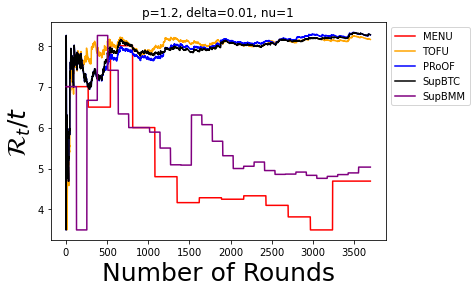

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


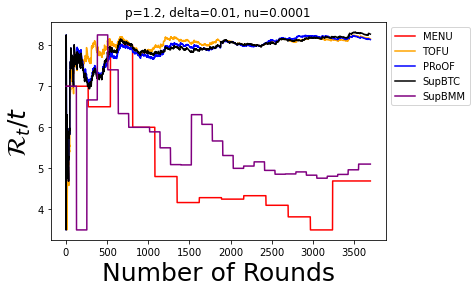

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


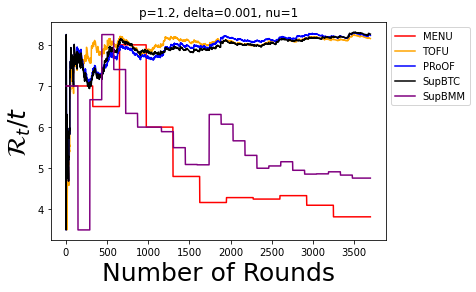

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


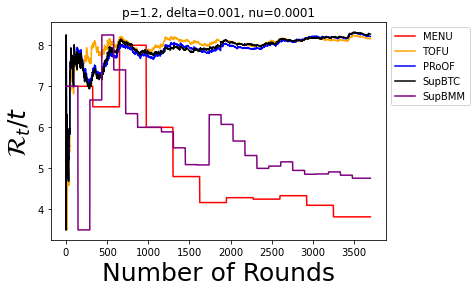

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


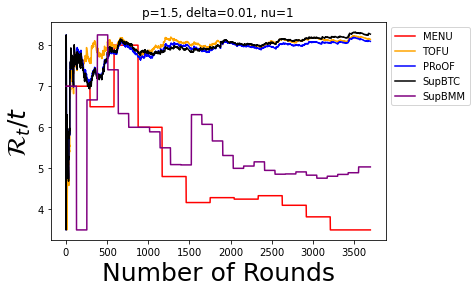

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


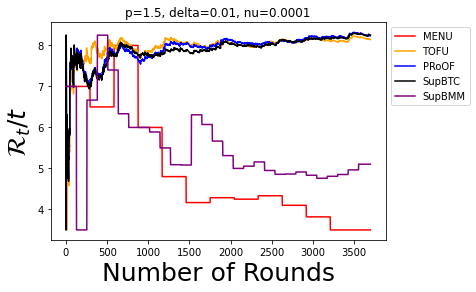

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


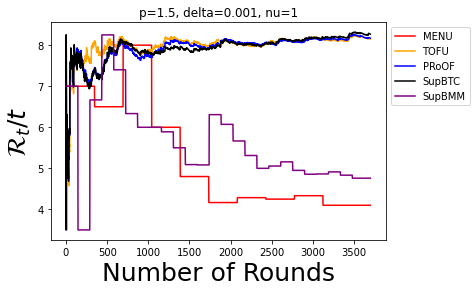

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


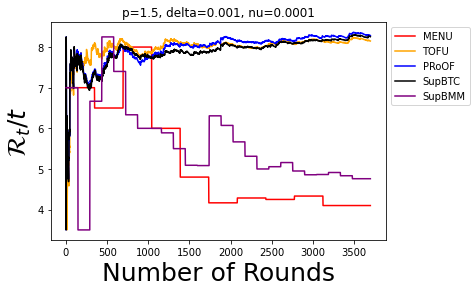

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


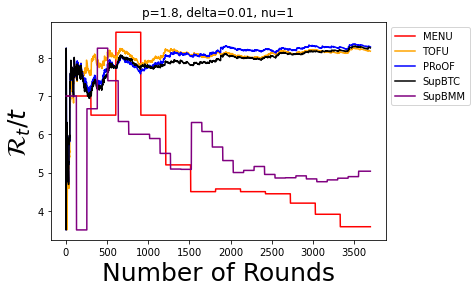

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


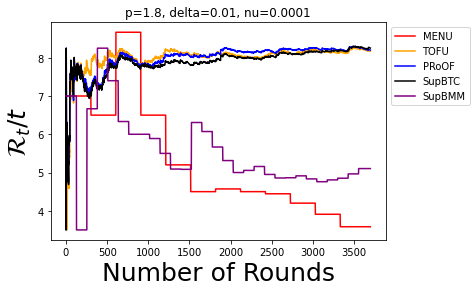

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


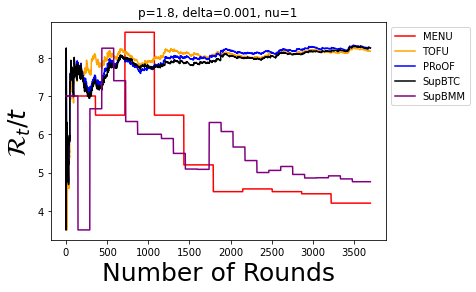

<Figure size 1440x1080 with 0 Axes>

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:149: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


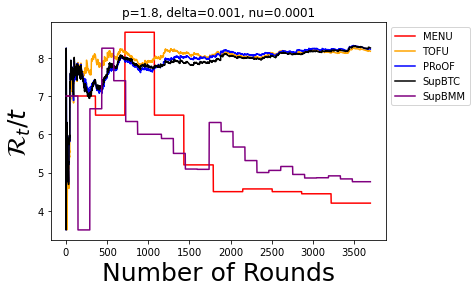

<Figure size 1440x1080 with 0 Axes>

In [49]:
for p in p_s:
    for delta in delta_s:
        for nu in nu_s:
            err = np.zeros((5,T))
            error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=delta, p=p, c=1.)
            err[0] = error_list

            error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=delta, p=p, b=1.)
            err[1] = error_list

            error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=delta, nu = nu, p=p)
            err[2] = error_list

            error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=delta, nu = nu, p=p)
            err[3] = error_list

            error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=delta, nu = nu, p=p)
            err[4] = error_list
            
            title = 'p=' + str(p) + ', delta=' + str(delta) + ', nu=' + str(nu)
            plt.title(title)
            plt.plot(err[0], color='red', label='MENU')
            plt.plot(err[1], color='orange', label='TOFU')
            plt.plot(err[2], color='blue', label='PRoOF')
            plt.plot(err[3], color='black', label='SupBTC')
            plt.plot(err[4], color='purple', label='SupBMM')

            plt.legend(bbox_to_anchor=(1, 1))
            plt.xlabel("Number of Rounds",fontsize=25)
            plt.ylabel("$\mathcal{R}_{t}/t$ ",fontsize=25)
            plt.figure(figsize=(20,15))
            plt.show()



In [ ]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
# error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)